In [320]:
import xgboost as xgb

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import holidays
holidays_de= holidays.Germany()

from sklearn.metrics import mean_squared_error

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

In [321]:
df_all = pd.read_csv('../../data_cleaned/merged/Merge_all_prices_load_gen_res.csv')
df_all.head()

,date,year,month,day,dayofyear,hour,week,dayofweek,price,period_start_utc,...,off_wind_da,off_wind_act,on_wind_da,on_wind_act,solar_da,solar_act,gen_forecast_da,gen_actual,res_sum_da,res_sum_act
0,2015-01-04,2015,1,4,4,23,1,6,22.34,2015-01-04 23:00:00,...,192.125,478.0200,11675.5250,14223.2775,0.0,0.1700,NaN,57028.5925,11867.6500,14701.4675
1,2015-01-05,2015,1,5,5,0,2,0,17.93,2015-01-05 00:00:00,...,192.375,468.5525,11924.5575,14207.5025,0.0,0.2075,NaN,56318.8525,12116.9325,14676.2625
2,2015-01-05,2015,1,5,5,1,2,0,15.17,2015-01-05 01:00:00,...,195.000,465.5550,12000.4075,14439.8025,0.0,0.1800,NaN,56216.6000,12195.4075,14905.5375
3,2015-01-05,2015,1,5,5,2,2,0,16.38,2015-01-05 02:00:00,...,193.625,454.0175,12108.2650,14584.6825,0.0,0.2000,NaN,56394.7350,12301.8900,15038.9000
4,2015-01-05,2015,1,5,5,3,2,0,17.38,2015-01-05 03:00:00,...,187.625,457.4750,12196.1175,15071.2450,0.0,0.1950,NaN,57670.7700,12383.7425,15528.9150


In [322]:
df_years = df_all.query('2019 <= year').copy()
df_years.head()

,date,year,month,day,dayofyear,hour,week,dayofweek,price,period_start_utc,...,off_wind_da,off_wind_act,on_wind_da,on_wind_act,solar_da,solar_act,gen_forecast_da,gen_actual,res_sum_da,res_sum_act
34969,2019-01-01,2019,1,1,1,0,1,1,10.07,2019-01-01 00:00:00,...,5042.4425,2868.2150,20626.5625,22315.6300,0.0,0.1350,51084.26,53141.07,25669.0050,25183.9800
34970,2019-01-01,2019,1,1,1,1,1,1,-4.08,2019-01-01 01:00:00,...,5028.4175,2460.4000,22355.6850,23193.3725,0.0,0.1225,51512.67,52534.02,27384.1025,25653.8950
34971,2019-01-01,2019,1,1,1,2,1,1,-9.91,2019-01-01 02:00:00,...,4977.6500,2696.6250,24032.4775,24508.7150,0.0,0.1250,52693.45,53217.19,29010.1275,27205.4650
34972,2019-01-01,2019,1,1,1,3,1,1,-7.41,2019-01-01 03:00:00,...,4907.4000,2577.7400,25452.1675,26373.4375,0.0,0.1300,53666.46,54735.54,30359.5675,28951.3075
34973,2019-01-01,2019,1,1,1,4,1,1,-12.55,2019-01-01 04:00:00,...,4882.8400,2377.3175,26526.3700,27931.3025,0.0,0.1275,54161.85,55846.36,31409.2100,30308.7475


In [323]:
df_years.drop(columns=['period_end_utc'], inplace=True)

In [324]:
df_years["period_start_utc"] = pd.to_datetime(df_years["period_start_utc"], errors="coerce")
df_years["date"] = pd.to_datetime(df_years["date"], errors="coerce")

In [325]:
df_years.info()

<class 'pandas.core.frame.DataFrame'>
Index: 61367 entries, 34969 to 96335
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              61367 non-null  datetime64[ns]
 1   year              61367 non-null  int64         
 2   month             61367 non-null  int64         
 3   day               61367 non-null  int64         
 4   dayofyear         61367 non-null  int64         
 5   hour              61367 non-null  int64         
 6   week              61367 non-null  int64         
 7   dayofweek         61367 non-null  int64         
 8   price             61367 non-null  float64       
 9   period_start_utc  61367 non-null  datetime64[ns]
 10  c_by_hour         61367 non-null  int64         
 11  load_forecast_da  61317 non-null  float64       
 12  load_actual       61367 non-null  float64       
 13  off_wind_da       61367 non-null  float64       
 14  off_wind_act      61367

In [326]:
df_years.set_index('period_start_utc', inplace=True)

In [327]:
df_years.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 61367 entries, 2019-01-01 00:00:00 to 2025-12-31 22:00:00
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              61367 non-null  datetime64[ns]
 1   year              61367 non-null  int64         
 2   month             61367 non-null  int64         
 3   day               61367 non-null  int64         
 4   dayofyear         61367 non-null  int64         
 5   hour              61367 non-null  int64         
 6   week              61367 non-null  int64         
 7   dayofweek         61367 non-null  int64         
 8   price             61367 non-null  float64       
 9   c_by_hour         61367 non-null  int64         
 10  load_forecast_da  61317 non-null  float64       
 11  load_actual       61367 non-null  float64       
 12  off_wind_da       61367 non-null  float64       
 13  off_wind_act      61367 non-null  float64

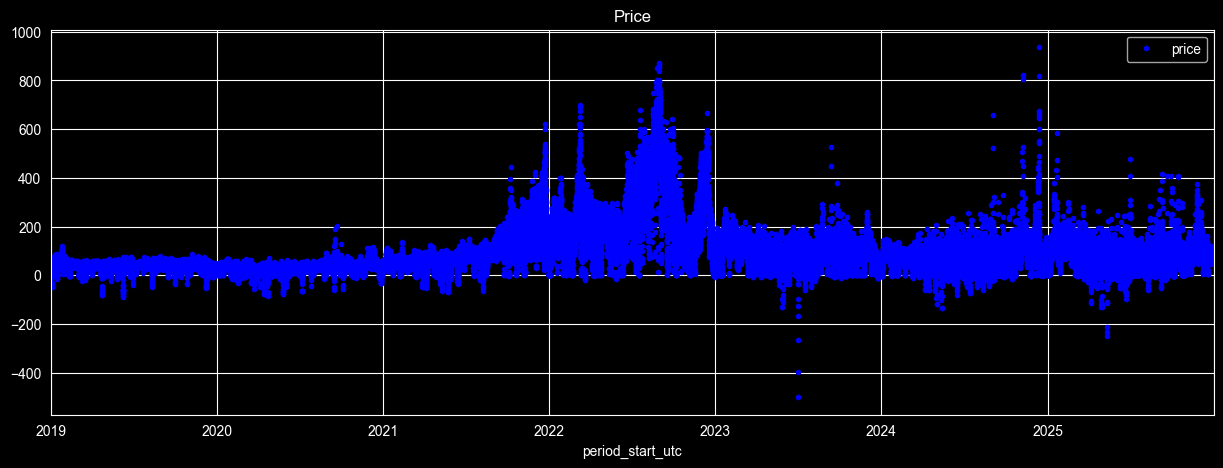

In [328]:
df_years.plot( y='price', style='.', figsize=(15, 5), color='blue', title='Price')
plt.show()

# Train / Test Split

In [329]:
start_date = pd.to_datetime('2019-01-01 00:00:00')
split_date = pd.to_datetime('2025-01-01 00:00:00')
end_date = pd.to_datetime('2026-01-01 00:00:00')

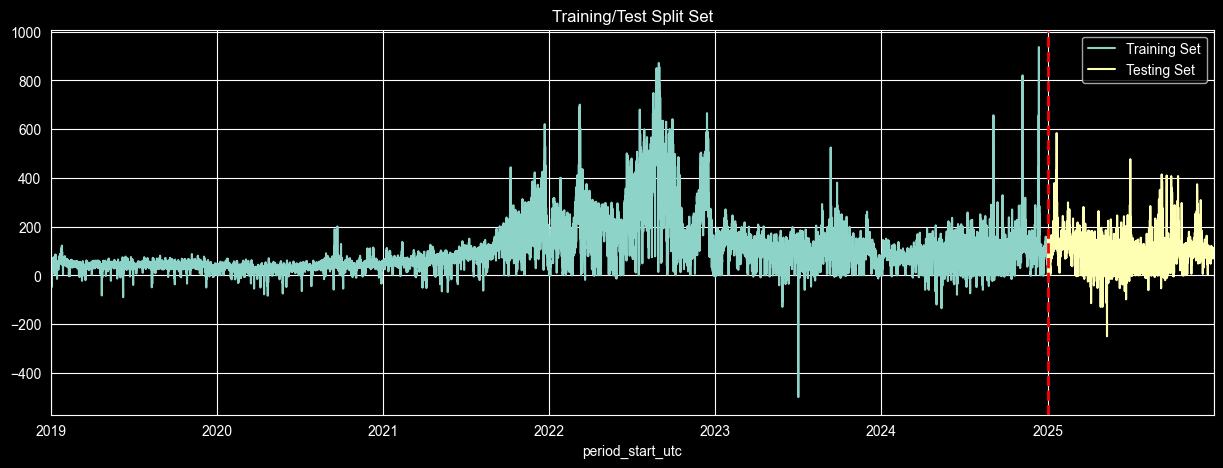

In [330]:
train = df_years.query('@start_date <= date < @split_date')
test = df_years.query('@split_date <= date < @end_date')

#train = df_years.query('date < 2021')
#test = df_years.query('2021 <= date < "2021-07"')

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(y='price', ax=ax, label='Training Set', title='Training/Test Split Set')
test.plot(y='price', ax=ax, label = 'Testing Set')
ax.axvline(split_date, color='red', linestyle='dashed', linewidth=2)
plt.legend()
plt.show()

# Feature Creation

In [331]:
df_years.index

DatetimeIndex(['2019-01-01 00:00:00', '2019-01-01 01:00:00',
               '2019-01-01 02:00:00', '2019-01-01 03:00:00',
               '2019-01-01 04:00:00', '2019-01-01 05:00:00',
               '2019-01-01 06:00:00', '2019-01-01 07:00:00',
               '2019-01-01 08:00:00', '2019-01-01 09:00:00',
               ...
               '2025-12-31 13:00:00', '2025-12-31 14:00:00',
               '2025-12-31 15:00:00', '2025-12-31 16:00:00',
               '2025-12-31 17:00:00', '2025-12-31 18:00:00',
               '2025-12-31 19:00:00', '2025-12-31 20:00:00',
               '2025-12-31 21:00:00', '2025-12-31 22:00:00'],
              dtype='datetime64[ns]', name='period_start_utc', length=61367, freq=None)

In [332]:
def create_features(df):
    """
    create time series features based on time series index
    :param df:
    :return:
    """
    df = df.copy()

    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['weekday'] = df.index.weekday
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

Text(0.5, 1.0, 'Price by Hour')

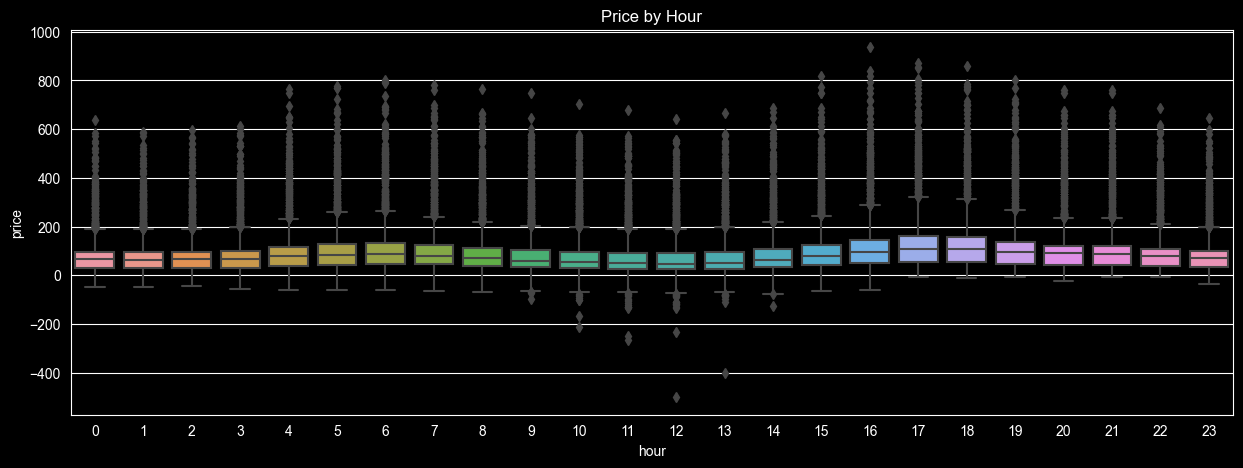

In [333]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(data = df_years, x = 'hour', y= 'price')
ax.set_title('Price by Hour')

Text(0.5, 1.0, 'Price by Month')

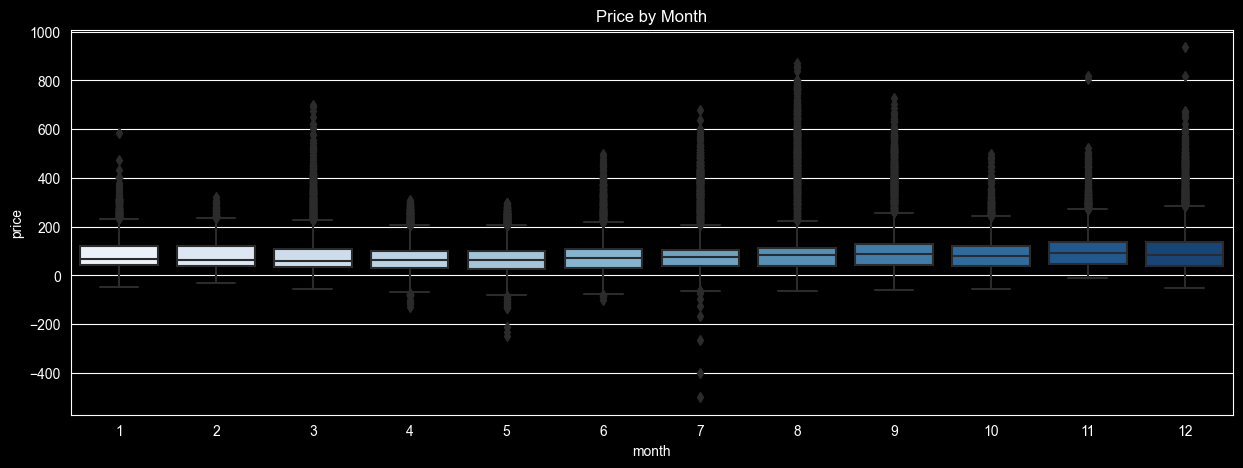

In [334]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(data = df_years, x = 'month', y= 'price', palette='Blues')
ax.set_title('Price by Month')

# Create Model

In [335]:
df_years.columns

Index(['date', 'year', 'month', 'day', 'dayofyear', 'hour', 'week',
       'dayofweek', 'price', 'c_by_hour', 'load_forecast_da', 'load_actual',
       'off_wind_da', 'off_wind_act', 'on_wind_da', 'on_wind_act', 'solar_da',
       'solar_act', 'gen_forecast_da', 'gen_actual', 'res_sum_da',
       'res_sum_act'],
      dtype='object')

In [336]:
FEATURES = ['year', 'month', 'day', 'dayofyear', 'hour', 'week', 'dayofweek', 'load_forecast_da', 'res_sum_da']
TARGET = 'price'

In [337]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [338]:
# n_estimators : number of trees being created
reg = xgb.XGBRegressor(base_score=0.5,
                       n_estimators=1000,
                       learning_rate=0.01,
                       early_stopping_rounds=500,
                       objective='reg:squarederror',
                       colsample_bytree=0.8,
                       subsample=0.8,
                       max_depth=5)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100 # True prints always, number gives the n-th result
        )

[0]	validation_0-rmse:136.78560	validation_1-rmse:102.47619
[100]	validation_0-rmse:70.70398	validation_1-rmse:48.94101
[200]	validation_0-rmse:44.74849	validation_1-rmse:34.01146
[300]	validation_0-rmse:34.04594	validation_1-rmse:30.38013
[400]	validation_0-rmse:29.41669	validation_1-rmse:29.22632
[500]	validation_0-rmse:26.99529	validation_1-rmse:29.05329
[600]	validation_0-rmse:25.15472	validation_1-rmse:29.33595
[700]	validation_0-rmse:23.72848	validation_1-rmse:29.75151
[800]	validation_0-rmse:22.59322	validation_1-rmse:30.17470
[900]	validation_0-rmse:21.75874	validation_1-rmse:30.48827
[992]	validation_0-rmse:21.20194	validation_1-rmse:30.63660


XGBRegressor(base_score=0.5, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=500,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

# Feature Importance

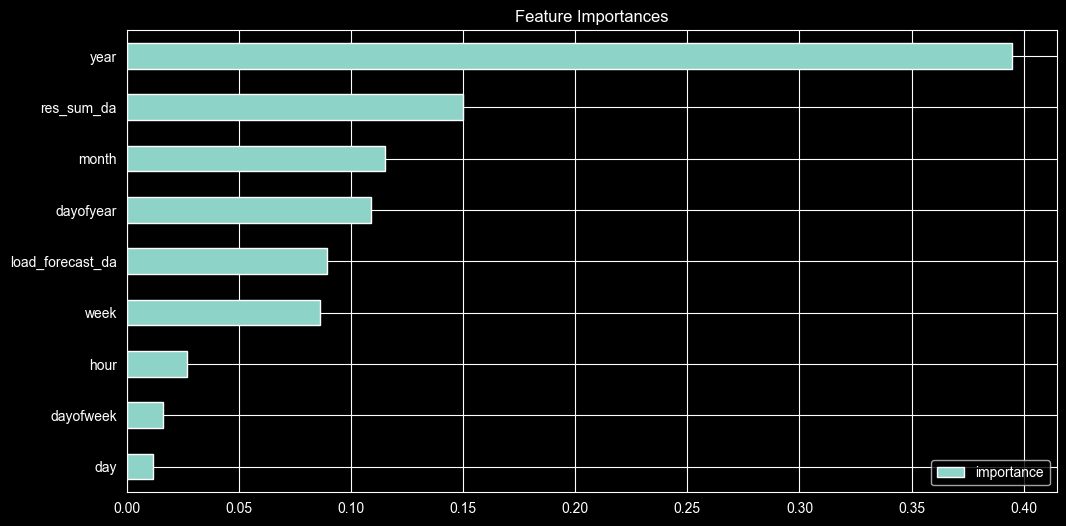

In [339]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance']
             )
fi.sort_values('importance').plot(kind='barh', title='Feature Importances')
plt.show()

# Forecast on Test

In [340]:
test['prediction'] = reg.predict(X_test)
test

C:\Users\bened\AppData\Local\Temp\ipykernel_20396\2874089957.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = reg.predict(X_test)


,date,year,month,day,dayofyear,hour,week,dayofweek,price,c_by_hour,...,off_wind_act,on_wind_da,on_wind_act,solar_da,solar_act,gen_forecast_da,gen_actual,res_sum_da,res_sum_act,prediction
period_start_utc,,,,,,,,,,,,,,,,,,,,,
2025-01-01 00:00:00,2025-01-01,2025,1,1,1,0,1,2,1.6000,4,...,2395.2675,39056.1575,33528.8575,0.0,9.5450,55957.8375,54045.3775,42851.2275,35933.6700,6.968142
2025-01-01 01:00:00,2025-01-01,2025,1,1,1,1,1,2,0.0000,4,...,2614.1375,39515.6400,33791.3450,0.0,9.2925,55580.8875,53702.3950,43341.8300,36414.7750,6.948909
2025-01-01 02:00:00,2025-01-01,2025,1,1,1,2,1,2,-0.0100,4,...,1684.2200,39477.0000,32901.5425,0.0,9.4125,53780.5125,51843.6050,42813.8875,34595.1750,6.763740
2025-01-01 03:00:00,2025-01-01,2025,1,1,1,3,1,2,-0.0100,4,...,1327.7375,39813.9475,33148.3950,0.0,9.2175,53570.5500,51611.3075,43027.5400,34485.3500,6.763740
2025-01-01 04:00:00,2025-01-01,2025,1,1,1,4,1,2,-0.0600,4,...,1162.9800,40329.6275,33611.1950,0.0,9.0950,53725.4400,51818.0300,43400.7125,34783.2700,6.948909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-12-31 18:00:00,2025-12-31,2025,12,31,365,18,1,2,95.9900,4,...,5418.4900,25289.8075,26949.3850,0.0,0.0675,58900.9800,60292.3475,30719.8550,32367.9425,99.270866
2025-12-31 19:00:00,2025-12-31,2025,12,31,365,19,1,2,86.8025,4,...,5015.0525,26179.9500,28002.9700,0.0,0.0525,58562.3375,58865.2100,31674.9400,33018.0750,88.639839
2025-12-31 20:00:00,2025-12-31,2025,12,31,365,20,1,2,79.7975,4,...,4390.0575,27294.2850,29909.6650,0.0,0.0575,57650.8775,59417.6050,32653.3850,34299.7800,81.377548


In [341]:
df_years = df_years.merge(test[['prediction']],  how = 'left', left_index=True, right_index=True) # merge on index columns

In [342]:
df_years

,date,year,month,day,dayofyear,hour,week,dayofweek,price,c_by_hour,...,off_wind_act,on_wind_da,on_wind_act,solar_da,solar_act,gen_forecast_da,gen_actual,res_sum_da,res_sum_act,prediction
period_start_utc,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,2019-01-01,2019,1,1,1,0,1,1,10.0700,4,...,2868.2150,20626.5625,22315.6300,0.0,0.1350,51084.2600,53141.0700,25669.0050,25183.9800,NaN
2019-01-01 01:00:00,2019-01-01,2019,1,1,1,1,1,1,-4.0800,4,...,2460.4000,22355.6850,23193.3725,0.0,0.1225,51512.6700,52534.0200,27384.1025,25653.8950,NaN
2019-01-01 02:00:00,2019-01-01,2019,1,1,1,2,1,1,-9.9100,4,...,2696.6250,24032.4775,24508.7150,0.0,0.1250,52693.4500,53217.1900,29010.1275,27205.4650,NaN
2019-01-01 03:00:00,2019-01-01,2019,1,1,1,3,1,1,-7.4100,4,...,2577.7400,25452.1675,26373.4375,0.0,0.1300,53666.4600,54735.5400,30359.5675,28951.3075,NaN
2019-01-01 04:00:00,2019-01-01,2019,1,1,1,4,1,1,-12.5500,4,...,2377.3175,26526.3700,27931.3025,0.0,0.1275,54161.8500,55846.3600,31409.2100,30308.7475,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-12-31 18:00:00,2025-12-31,2025,12,31,365,18,1,2,95.9900,4,...,5418.4900,25289.8075,26949.3850,0.0,0.0675,58900.9800,60292.3475,30719.8550,32367.9425,99.270866
2025-12-31 19:00:00,2025-12-31,2025,12,31,365,19,1,2,86.8025,4,...,5015.0525,26179.9500,28002.9700,0.0,0.0525,58562.3375,58865.2100,31674.9400,33018.0750,88.639839
2025-12-31 20:00:00,2025-12-31,2025,12,31,365,20,1,2,79.7975,4,...,4390.0575,27294.2850,29909.6650,0.0,0.0575,57650.8775,59417.6050,32653.3850,34299.7800,81.377548


In [343]:
df_years.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 61367 entries, 2019-01-01 00:00:00 to 2025-12-31 22:00:00
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              61367 non-null  datetime64[ns]
 1   year              61367 non-null  int64         
 2   month             61367 non-null  int64         
 3   day               61367 non-null  int64         
 4   dayofyear         61367 non-null  int64         
 5   hour              61367 non-null  int64         
 6   week              61367 non-null  int64         
 7   dayofweek         61367 non-null  int64         
 8   price             61367 non-null  float64       
 9   c_by_hour         61367 non-null  int64         
 10  load_forecast_da  61317 non-null  float64       
 11  load_actual       61367 non-null  float64       
 12  off_wind_da       61367 non-null  float64       
 13  off_wind_act      61367 non-null  float64

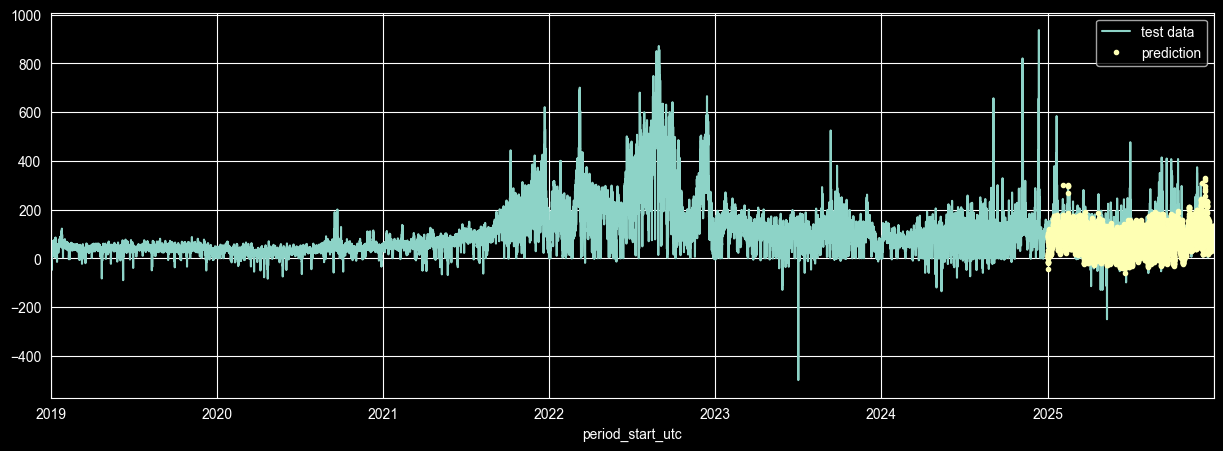

Text(0.5, 1.0, 'Test Data and Predictions')

In [344]:
ax = df_years[['price']].plot(figsize=(15, 5))
df_years['prediction'].plot(ax=ax, style = '.')
plt.legend(['test data', 'prediction'])
plt.show()
ax.set_title('Test Data and Predictions')

# smaller test frames

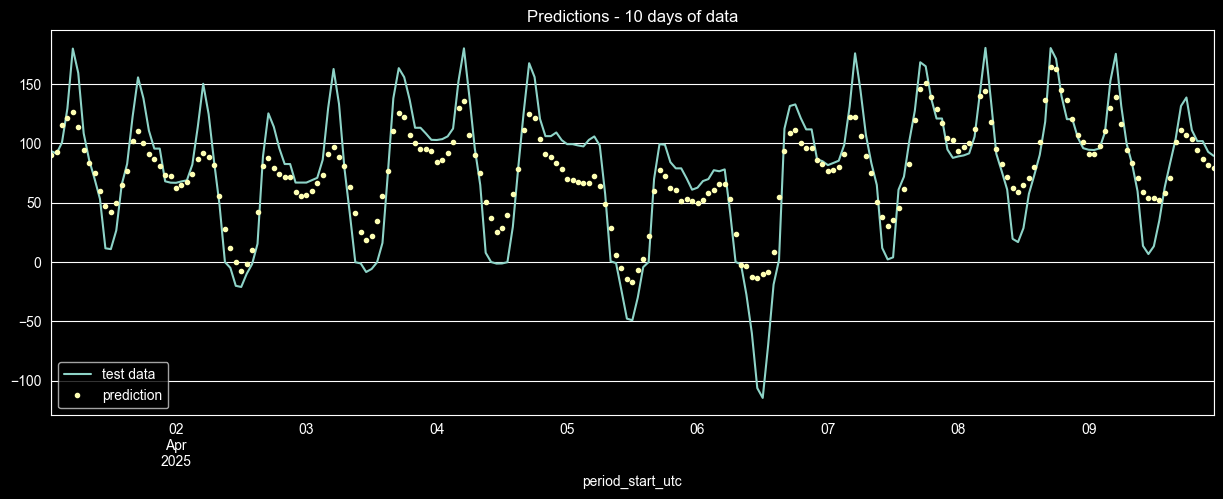

In [345]:
ax = df_years.loc[("2025-04-01" < df_years.index) & (df_years.index < "2025-04-10")]['price'].plot(figsize=(15, 5), title='Predictions - 10 days of data')
df_years.loc[("2025-04-01" < df_years.index) & (df_years.index < "2025-04-10")]['prediction'].plot(ax=ax, style='.')
plt.legend(['test data', 'prediction'])
plt.show()

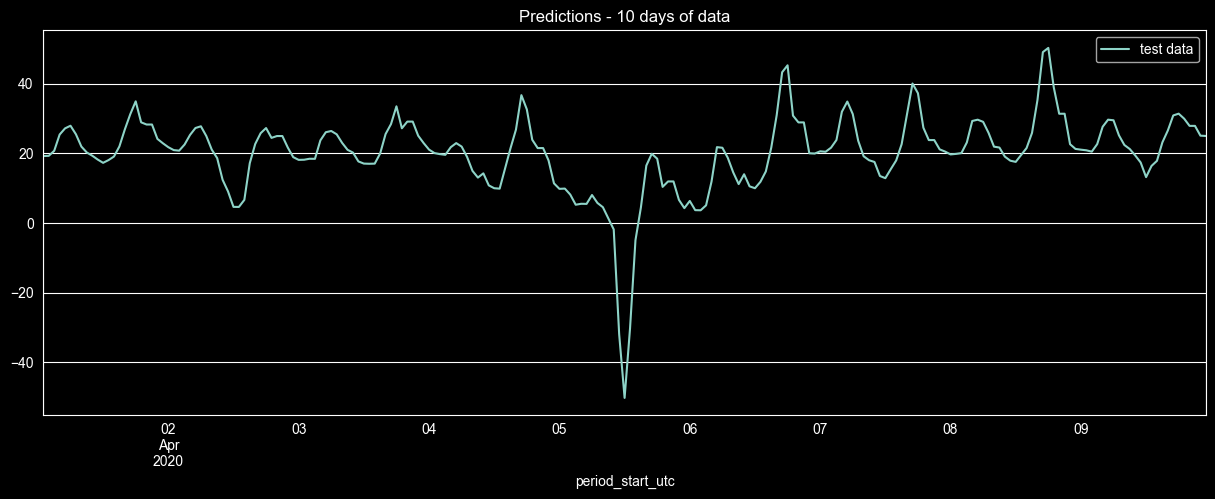

In [346]:
ax = df_years.loc[("2020-04-01" < df_years.index) & (df_years.index < "2020-04-10")]['price'].plot(figsize=(15, 5), title='Predictions - 10 days of data')
plt.legend(['test data'])
plt.show()

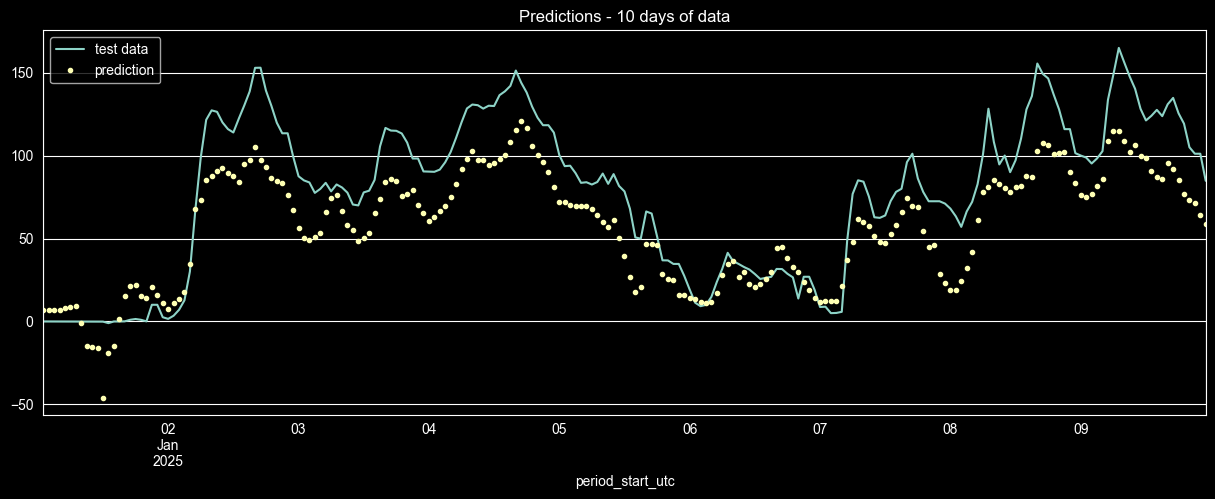

In [347]:
ax = df_years.loc[("2025-01-01" < df_years.index) & (df_years.index < "2025-01-10")]['price'].plot(figsize=(15, 5), title='Predictions - 10 days of data')
df_years.loc[("2025-01-01" < df_years.index) & (df_years.index < "2025-01-10")]['prediction'].plot(ax=ax, style='.')
plt.legend(['test data', 'prediction'])
plt.show()